In [1]:
import ROOT
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import array
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import matplotlib.transforms as mtransforms
from itertools import groupby
from operator import itemgetter
from scipy.stats import norm

Welcome to JupyROOT 6.28/00


In [2]:
#Opening .root file and creating dataframes from it's TTrees
file = uproot.open("data/digi_00000154.root")
dataframes = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df = tree.arrays(library="pd")
        dataframes[key] = df.astype(int)

In [3]:
#Delete unused columns and create df for work
dataframes['outputtree;1'].drop("orbitNumber", axis=1, inplace=True)
dataframes['outputtree;1'].drop("bunchCounter", axis=1, inplace=True)
dataframes['outputtree;1'].drop("runParameter", axis=1, inplace=True)
dataframes['outputtree;1'].drop("pulse_stretch", axis=1, inplace=True)
dataframes['outputtree;1'].drop("slot", axis=1, inplace=True)
dataframes['outputtree;1'].drop("OH", axis=1, inplace=True)
dataframes['outputtree;1'].drop("CH", axis=1, inplace=True)
dataframes['outputtree;1'].drop("digiDirection", axis=1, inplace=True)

dataframes['outputtree;2'].drop("orbitNumber", axis=1, inplace=True)
dataframes['outputtree;2'].drop("bunchCounter", axis=1, inplace=True)
dataframes['outputtree;2'].drop("runParameter", axis=1, inplace=True)
dataframes['outputtree;2'].drop("pulse_stretch", axis=1, inplace=True)
dataframes['outputtree;2'].drop("slot", axis=1, inplace=True)
dataframes['outputtree;2'].drop("OH", axis=1, inplace=True)
dataframes['outputtree;2'].drop("CH", axis=1, inplace=True)
dataframes['outputtree;2'].drop("digiDirection", axis=1, inplace=True)
df = dataframes['outputtree;2']
df = df.reset_index()
df.drop("subentry", axis=1, inplace=True)
df.drop("eventCounter", axis=1, inplace=True)

In [46]:
df[df['entry']==1]

entry  VFAT  digiBX  digiChamber  digiEta  digiStrip
20      1    13       1            2        3        187
21      1    13       1            2        3        186
22      1    13       1            2        3        185
23      1    13       2            1        3        189
24      1    13       2            1        3        188
25      1    13       2            1        3        187
26      1    13       2            2        3        188
27      1    13       2            2        3        133
28      1    13       2            2        3        184
29      1    13       3            0        3        191
30      1    13       3            0        3        129
31      1    13       3            0        3        190
32      1    13       3            0        3        130
33      1    13       3            0        3        189
34      1    13       3            0        3        131
35      1    13       3            0        3        188
36      1    13       3            0        3        132
37      1    13       3            0        3        187
38      1    13       3            0        3        186
39      1    13       3            0        3        192
40      1    13       3            1        3        190
41      1    13       3            1        3        131
42      1    13       3            1        3        132
43      1    13       3            1        3        186
44      1    13       3            3        3        184
45      1    13       4            0        3        128
46      1    13       5            3        3        185
47      1    13      11            2        3        185
48      1    13      12            0        3        191
49      1    13      12            1        3        189
50      1    13      13            0        3        188
51      1    13      14            0        3        130

    entry  VFAT  digiBX  digiChamber  digiEta  digiStrip  cluster
45      1    13       4            0        3        128        1
30      1    13       3            0        3        129        1
32      1    13       3            0        3        130        1
51      1    13      14            0        3        130        1
34      1    13       3            0        3        131        1
36      1    13       3            0        3        132        1
38      1    13       3            0        3        186        2
37      1    13       3            0        3        187        2
35      1    13       3            0        3        188        2
50      1    13      13            0        3        188        2
33      1    13       3            0        3        189        2
31      1    13       3            0        3        190        2
29      1    13       3            0        3        191        2
48      1    13      12            0        3        191        2
39      1 

/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


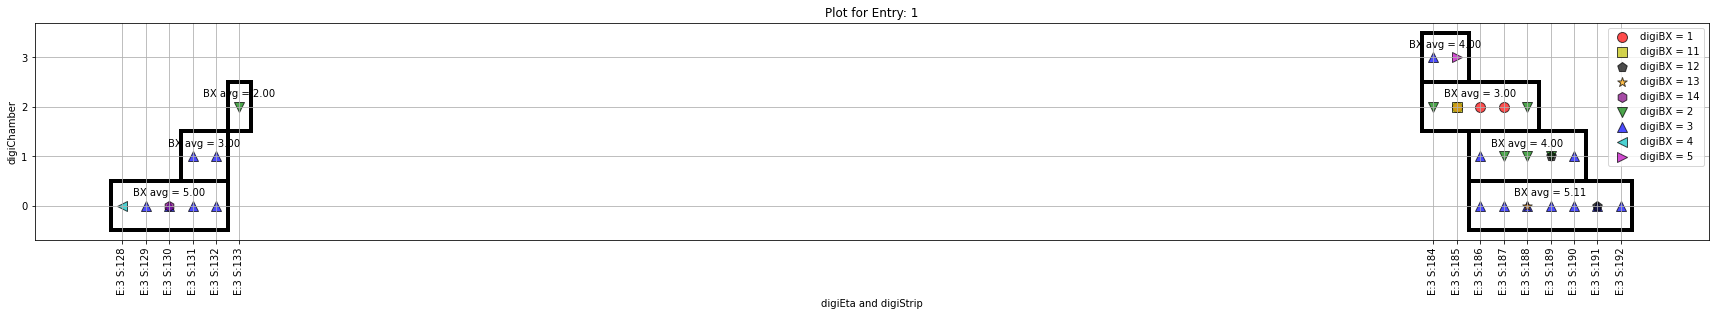

In [19]:
def plot_digi(df: pd.DataFrame, entry: int, min_bx: int, max_bx: int) -> None:
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    # Filter dataframe by entry and digiBX range
    df_entry = df[(df['entry'] == entry) & (df['digiBX'] >= min_bx) & (df['digiBX'] <= max_bx)]
    
    # Add a cluster column based on chamber, eta and strip sequence
    df_entry = df_entry.sort_values(['digiChamber', 'digiEta', 'digiStrip'])
    df_entry['cluster'] = (df_entry['digiChamber'].ne(df_entry['digiChamber'].shift()) | 
                           df_entry['digiEta'].ne(df_entry['digiEta'].shift()) | 
                           ~df_entry['digiStrip'].diff().isin([0,1])).cumsum()
    print(df_entry)
    fig, ax = plt.subplots(figsize=(30, 4))
    
    unique_digi_bx = sorted(list(df_entry['digiBX'].unique()))
    print(unique_digi_bx)

    for idx, digi_bx in enumerate(unique_digi_bx):
        df_bx = df_entry[df_entry['digiBX'] == digi_bx]
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        ax.scatter(df_bx['digiStrip'], df_bx['digiChamber'], c=color, 
                   marker=marker, s=100, edgecolor='black', linewidth=1, 
                   label=f'digiBX = {digi_bx}', alpha=0.7)

    # Display cluster rectangles and average digiBX
    cluster_df = df_entry.groupby('cluster').agg({'digiChamber': 'first', 'digiEta': ['min', 'max'], 
                                                  'digiStrip': ['min', 'max'], 'digiBX': 'mean'}).reset_index()

    for _, row in cluster_df.iterrows():
        rectangle = patches.Rectangle((row['digiStrip']['min']-0.5, row['digiChamber']-0.5), 
                                      row['digiStrip']['max'] - row['digiStrip']['min']+1, 1, 
                                      linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text((row['digiStrip']['min'] + row['digiStrip']['max']) / 2, row['digiChamber'] + 0.2, 
                f"BX avg = {row['digiBX']['mean']:.2f}", horizontalalignment='center')

    plt.yticks(range(0, 4))
    unique_x_labels = df_entry[['digiEta', 'digiStrip']].drop_duplicates()
    ax.set_xticks(unique_x_labels['digiStrip'])
    ax.set_xticklabels(['E:{} S:{}'.format(eta, strip) for eta, strip in zip(unique_x_labels['digiEta'], unique_x_labels['digiStrip'])], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title('Plot for Entry: {}'.format(entry))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))  # Sort labels and handles
    ax.legend(handles, labels)
    plt.grid(True)
    plt.show()

plot_digi(df, 1, 1, 20)

In [ ]:
def create_cluster_df(df: pd.DataFrame, entry_range: tuple = None, bx_range: tuple = None, filename: str = 'cluster.root') -> None:
    # If entry range is provided, filter dataframe by entry range
    if entry_range:
        df = df[(df['entry'] >= entry_range[0]) & (df['entry'] <= entry_range[1])]
    
    # If BX range is provided, filter dataframe by BX range
    if bx_range:
        df = df[(df['digiBX'] >= bx_range[0]) & (df['digiBX'] <= bx_range[1])]
    
    # Sort values by 'entry', 'digiChamber', 'digiEta', 'digiStrip'
    df = df.sort_values(['entry', 'digiChamber', 'digiEta', 'digiStrip'])

    # Define a function for creating clusters within a group
    def cluster_group(g):
        g['digiCluster'] = (g['digiChamber'].ne(g['digiChamber'].shift()) | 
                            g['digiEta'].ne(g['digiEta'].shift()) | 
                            ~g['digiStrip'].diff().isin([0,1])).cumsum()
        return g

    # Apply the cluster_group function to each 'entry' group
    df = df.groupby('entry').apply(cluster_group)

    # Create cluster dataframe
    cluster_df = df.groupby(['digiCluster', 'entry']).agg({
        'digiBX': ['mean', 'min', 'max'],
        'digiStrip': ['mean', 'min', 'max'],
        'digiChamber': 'first',
        'digiEta': 'first'
    }).reset_index()
    cluster_df.columns = ['_'.join(col) for col in cluster_df.columns]

    # Create a ROOT file
    root_file = ROOT.TFile(filename, "RECREATE")

    # Create a tree
    tree = ROOT.TTree("cluster", "cluster")

    # Define variables to hold the values for each branch
    data = {column: array.array('d', [0]) for column in cluster_df.columns}

    # Create the branches
    for column in cluster_df.columns:
        tree.Branch(column, data[column], f"{column}/D")

    # Fill the tree
    for i in range(cluster_df.shape[0]):
        for column in cluster_df.columns:
            data[column][0] = cluster_df.at[i, column]
        tree.Fill()

    # Write the tree into the ROOT file and close it
    tree.Write()
    root_file.Close()




# Usage:
create_cluster_df(df, bx_range = (0, 7), filename = 'data/cluster.root')


In [8]:
#Opening cluster .root file and creating dataframes from it's TTrees
file = uproot.open("data/cluster.root")
dataframes_cluster = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df_clus = tree.arrays(library="pd")
        dataframes_cluster[key] = df_clus.astype(float)
df_cluster=dataframes_cluster['cluster;1']

In [9]:
df_cluster

digiCluster_   entry_  digiBX_mean  digiBX_min  digiBX_max  \
0                1.0      1.0     3.200000         3.0         4.0   
1                1.0      2.0     2.666667         2.0         3.0   
2                1.0      3.0     4.000000         4.0         4.0   
3                1.0      4.0     2.333333         2.0         3.0   
4                1.0      5.0     2.666667         2.0         3.0   
...              ...      ...          ...         ...         ...   
530099         273.0  99409.0     3.000000         3.0         3.0   
530100         274.0  64810.0     3.000000         3.0         3.0   
530101         274.0  99409.0     2.666667         2.0         3.0   
530102         275.0  64810.0     3.000000         3.0         3.0   
530103         276.0  64810.0     3.000000         3.0         3.0   

        digiStrip_mean  digiStrip_min  digiStrip_max  digiChamber_first  \
0                130.0          128.0          132.0                0.0   
1                142.0          141.0          143.0                0.0   
2                 46.0           46.0           46.0                0.0   
3                181.0          180.0          182.0                0.0   
4                 57.0           56.0           58.0                0.0   
...                ...            ...            ...                ...   
530099           241.5          241.0          242.0                3.0   
530100           326.5          326.0          327.0                3.0   
530101           323.0          322.0          324.0                3.0   
530102           332.5          332.0          333.0                3.0   
530103           343.0          343.0          343.0                3.0   

        digiEta_first  
0                 3.0  
1                 3.0  
2                 3.0  
3                 4.0  
4                 3.0  
...               ...  
530099            4.0  
530100            4.0  
530101            4.0  
530102            4.0  
530103            4.0  

[530104 rows x 10 columns]

Fitting parameters: [-0.50814332 27.35179153]
Average BX: 3.1458333333333335


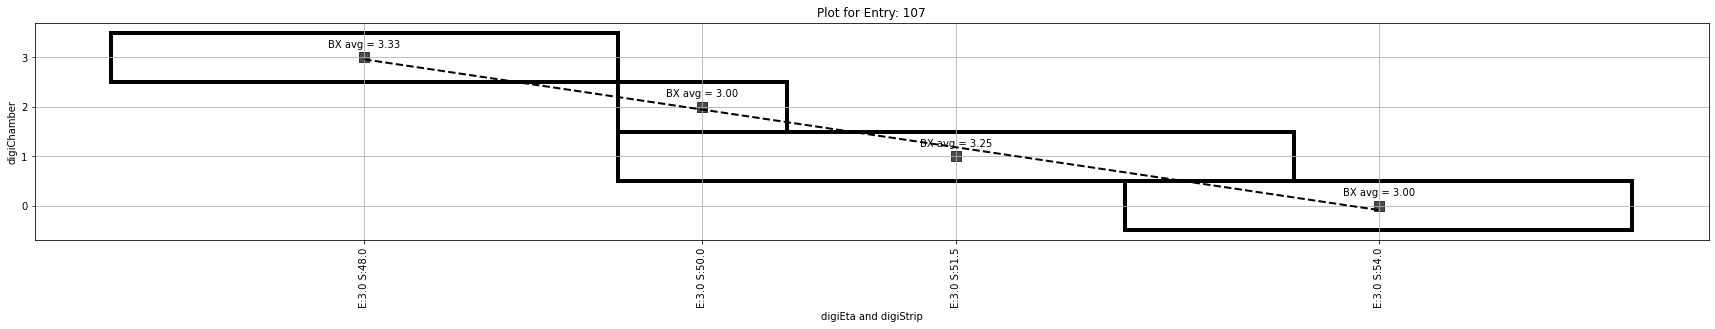

In [71]:
def check_event(df, event):
    # Filter dataframe by event
    df_event = df[df['entry_'] == event]
    
    # Count the number of clusters in each chamber
    cluster_counts = df_event['digiChamber_first'].value_counts()
    
    # Check if there is exactly one cluster in each chamber
    if not all(count == 1 for count in cluster_counts):
#         print("bad event")
        return False
    else:
        return True

def plot_event(df, event):
    if not check_event(df, event):
        print("bad event")
        return
    
    # Filter dataframe by event
    df_event = df[df['entry_'] == event]

    # Prepare data for plotting and fitting
    x = df_event['digiStrip_mean']
    y = df_event['digiChamber_first']
    
    # Fit the points to a line
    coefficients = np.polyfit(x, y, 1)
    poly = np.poly1d(coefficients)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = poly(x_fit)

    # Plot style configuration
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
#     markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    fig, ax = plt.subplots(figsize=(30, 4))
    
    for idx, row in df_event.iterrows():
        ax.scatter(row['digiStrip_mean'], row['digiChamber_first'], c='black', 
                   marker='s', s=100, edgecolor='black', linewidth=1,
                   alpha=0.7)
        rectangle = patches.Rectangle((row['digiStrip_min']-0.5, row['digiChamber_first']-0.5), 
                                      row['digiStrip_max'] - row['digiStrip_min']+1, 1, 
                                      linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text(row['digiStrip_mean'], row['digiChamber_first'] + 0.2, 
                f"BX avg = {row['digiBX_mean']:.2f}", horizontalalignment='center')
    
    # Plot fitted line
    ax.plot(x_fit, y_fit, color='black', linewidth=2, linestyle='--')

    plt.yticks(range(0, 4))
    ax.set_xticks(df_event['digiStrip_mean'])
    ax.set_xticklabels([f"E:{row['digiEta_first']} S:{row['digiStrip_mean']}" for _, row in df_event.iterrows()], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title(f'Plot for Entry: {event}')
    
    # Print fitting parameters
    print(f"Fitting parameters: {coefficients}")
    
    # Print average BX
    avg_bx = df_event['digiBX_mean'].mean()
    print(f"Average BX: {avg_bx}")
    
    plt.grid(True)
    plt.show()

plot_event(df_cluster, 107)

In [11]:
def process_df(df):
    # Copy the dataframe
    df_copy = df.copy()

    # Add column for good/bad event
    df_copy['good_event'] = df_copy['entry_'].apply(lambda event: check_event(df_copy, event))

    # Add column for average BX
    df_copy['avg_BX'] = df_copy.groupby('entry_')['digiBX_mean'].transform('mean')

    return df_copy
df_cluster_processed = process_df(df_cluster)

In [17]:
df_cluster_processed['entry_']

0             1.0
1             2.0
2             3.0
3             4.0
4             5.0
           ...   
530099    99409.0
530100    64810.0
530101    99409.0
530102    64810.0
530103    64810.0
Name: entry_, Length: 530104, dtype: float64

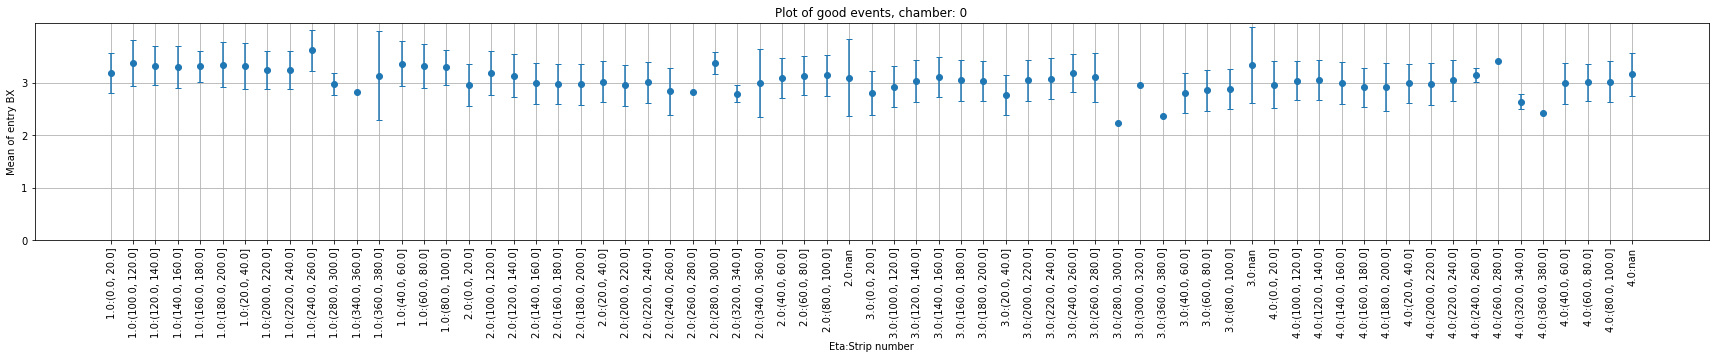

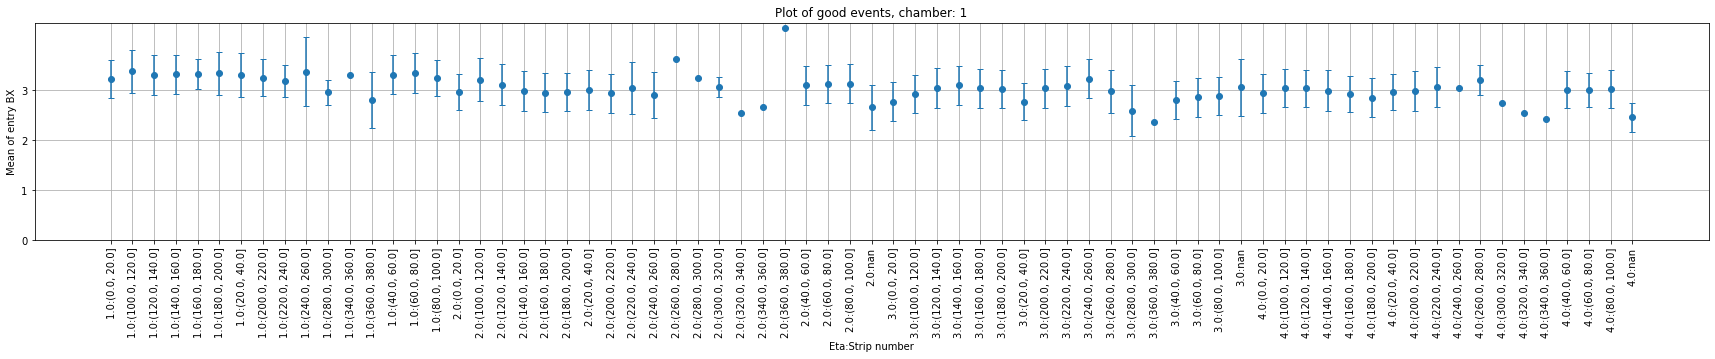

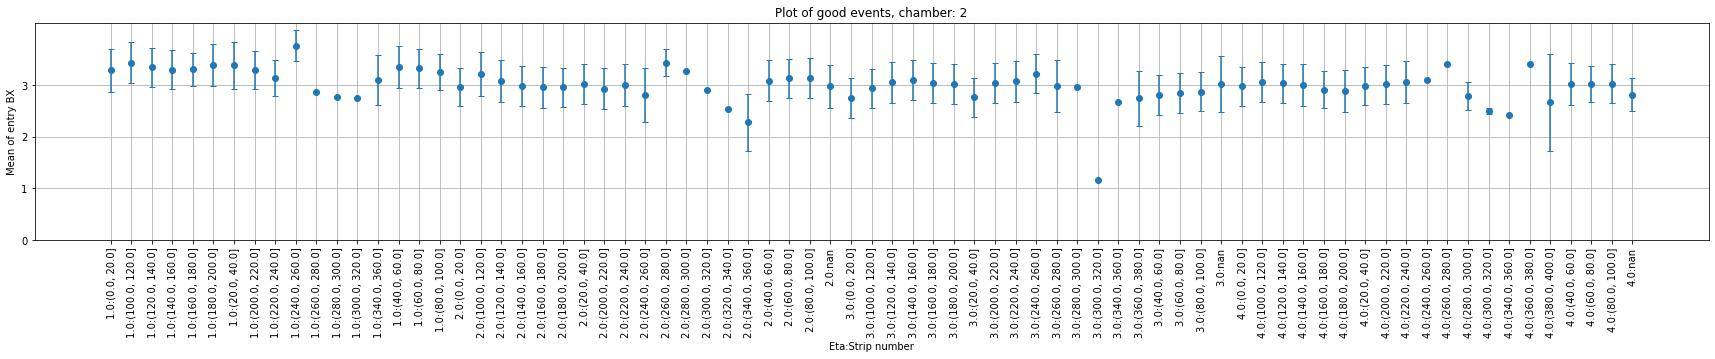

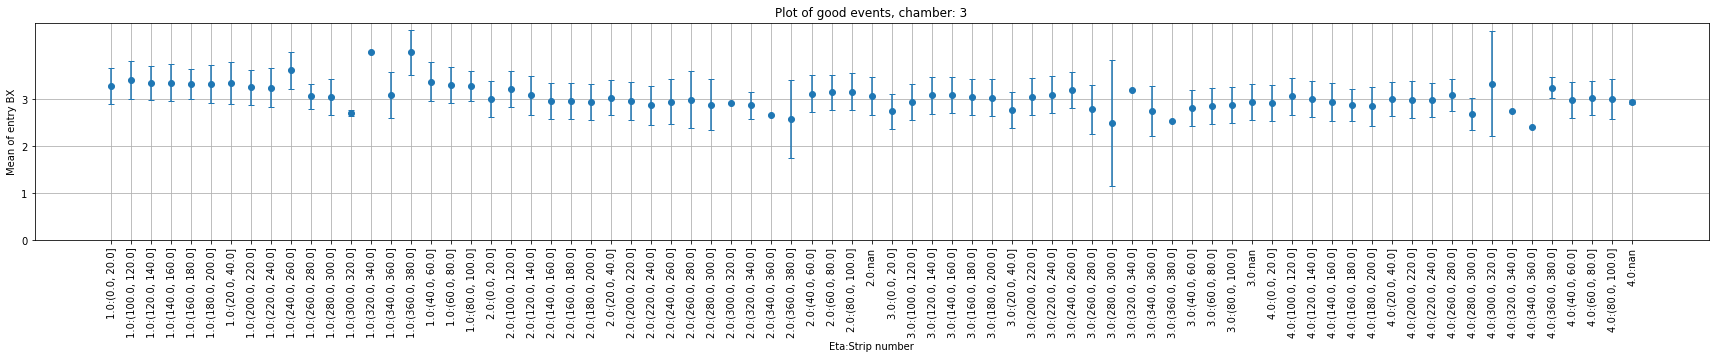

In [61]:
#On X axe we have average digiStrip_mean(which corresponds to CLUSTER) within selected bin width, y - average entry BX.
def plot_good_events(df, chamber, strip_bin_width):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber_first']==chamber]
    fig, ax = plt.subplots(figsize=(30, 4))
    # Create bins for strip
    df['strip_bin'] = pd.cut(df['digiStrip_mean'], np.arange(0, df['digiStrip_mean'].max() + strip_bin_width, strip_bin_width))

    # Create a combined column for 'digiEta_first' and 'strip_bin'
    df['eta_strip'] = df['digiEta_first'].astype(str) + ':' + df['strip_bin'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')['avg_BX'].agg(['mean', 'std'])

    # We sort the index to maintain the order of Eta and Strip while plotting
    grouped = grouped.sort_index()

    # Plot the data with error bars
    plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=3)

    plt.xticks(rotation=90) # This will rotate x-axis labels for better readability
    plt.yticks(range(0, 4))
    plt.xlabel('Eta:Strip number')
    plt.ylabel('Mean of entry BX')
    plt.title(f'Plot of good events, chamber: {chamber}')
    plt.grid(True)
    plt.show()

for i in range(0, 4):
    plot_good_events(df_cluster_processed,i, 20)

In [28]:
df_cluster_processed['digiBX_mean']

0         3.200000
1         2.666667
2         4.000000
3         2.333333
4         2.666667
            ...   
530099    3.000000
530100    3.000000
530101    2.666667
530102    3.000000
530103    3.000000
Name: digiBX_mean, Length: 530104, dtype: float64